## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

### Read data into DFs

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [3]:
target_map = {
'<=50K': 0,
'>50K': 1,
'<=50K.': 0,
'>50K.': 1
}

train_df['pred'] = train_df['pred'].str.strip().map(target_map)
test_df['pred'] = test_df['pred'].str.strip().map(target_map)

In [4]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

def strip_whitespace(df):
    
    # Remove trailing period if present
    df['pred'] = df['pred'].str.rstrip('.')

    return df

def replace_qmarks(df):
    
    # Convert "?" to missing values (NaN) in both dataframes
    df.replace("?", np.nan, inplace=True)
    
    return df

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
        
    return df



In [5]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

NameError: name 'preprocessing' is not defined

In [6]:
chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

chart_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [7]:
def plot_prevalence_subplots(df, categories, pred_col='pred'):
    n = len(categories)
    rows = (n + 2) // 3          # auto-fit 3 plots per row
    cols = min(n, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, cat in enumerate(categories):
        ax = axes[i]
        
        prevalence = df.groupby(cat)[pred_col].mean()

        prevalence.plot(kind='bar', ax=ax)

        ax.set_title(f"Target prevalence by '{cat}' group")
        ax.set_ylabel("Proportion with target = 1")
        ax.set_xlabel(cat)

    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

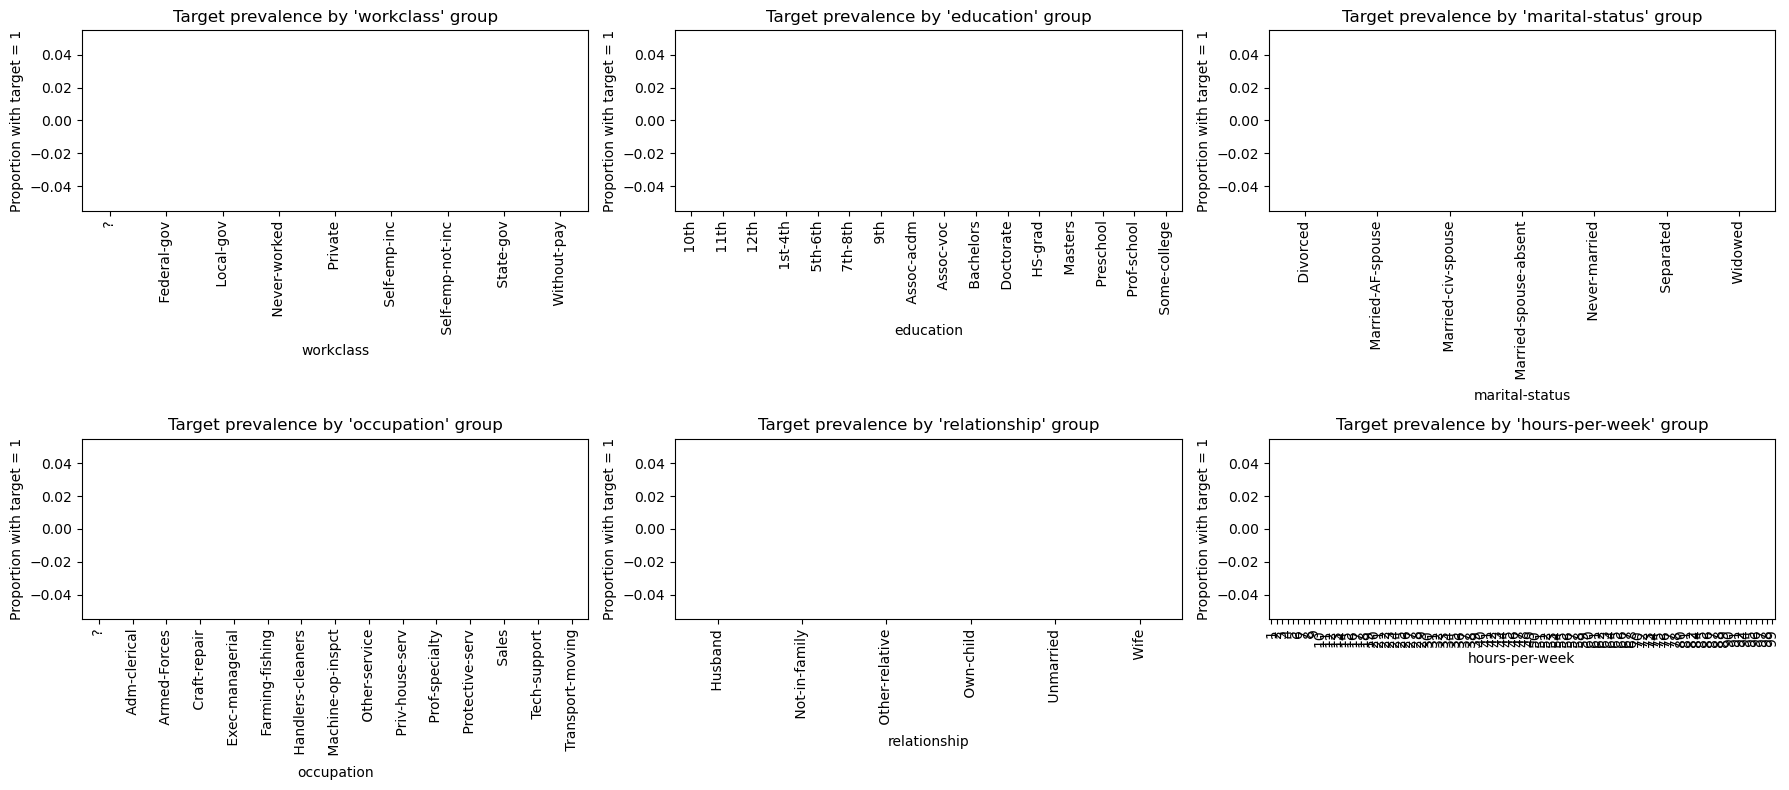

In [8]:
cats = ['workclass','education','marital-status','occupation','relationship','hours-per-week']

plot_prevalence_subplots(chart_df, cats)

## Recategorize the Categorical features into more meaningful groups

In [9]:
def category_remapping(df):

    copy_df = df.copy()
    
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    
    # Apply mapping and insert into dataframe
    copy_df.insert(2,'workclass-cat',copy_df['workclass'].map(workclass_mapping))
    
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    
    copy_df.insert(4,"education-cat",copy_df['education'].map(edu_mapping))
    
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    
    copy_df.insert(7,'marital-cat',copy_df['marital-status'].map(marital_mapping))

    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
    
        'Armed-Forces':'Military',
    
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    
    copy_df.insert(10,'occupation-cat',copy_df['occupation'].map(occupation_mapping))

    s = copy_df['native-country']
    
    native_imm_cat = (
        s.map({'United-States': 'Native'})         # US → Native, others → NaN
         .fillna('Immigrant')                     # non-US, non-missing → Immigrant
         .where(s.notna(), pd.NA)                 # where original was missing, keep NA
    )
    
    native_imm_cat.replace({pd.NA:np.nan}, inplace = True)
    
    copy_df.insert(18, 'native_imm_cat', native_imm_cat)

    hrs_bins = [0, 30, 40, 60, 100]
    hrs_labels = ['Part-Time', 'Underworked', 'Full-Time+', 'Overworked']
    
    copy_df['hours_bin'] = pd.cut(
        copy_df['hours-per-week'], 
        bins=hrs_bins, 
        labels=hrs_labels
    )

    copy_df.loc[:, 'net-capital-flow'] = df['capital-gain'] - df['capital-loss']

    cap_bins = [-10000, 10000, 99999]
    cap_labels = ['Standard', 'High Net-Worth']
    
    copy_df['cap_flow_bin'] = pd.cut(
        copy_df['net-capital-flow'], 
        bins=cap_bins, 
        labels=cap_labels
    )

    # drop all adjusted categorical features in favor of their derived categories
    copy_df.drop(['workclass','fnlwgt','education','education-num','marital-status','occupation','native-country','hours-per-week', 'capital-gain', 'capital-loss','net-capital-flow'], axis = 1, inplace = True)

    return copy_df

In [10]:
train_df = category_remapping(train_df)
test_df = category_remapping(test_df)

chart_df = train_df.copy()

chart_df['pred'] = np.where(chart_df['pred'] == '>50K',1,0)

/var/folders/js/tqvb2m154v73xsdw47trh9xh0000gn/T/ipykernel_41074/2248164938.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = chart_df.groupby('cap_flow_bin')['pred'].mean().sort_values()


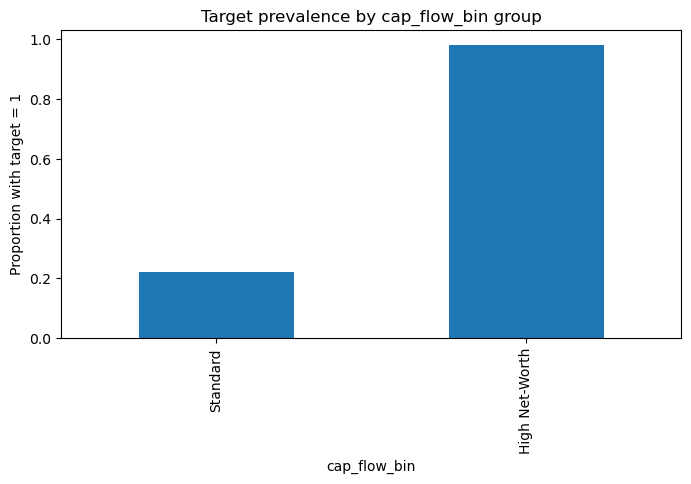

In [253]:
# Mean of a binary variable = prevalence/proportion
prevalence = chart_df.groupby('cap_flow_bin')['pred'].mean().sort_values()

prevalence.plot(kind='bar', figsize=(8,4))
plt.ylabel("Proportion with target = 1")
plt.title("Target prevalence by cap_flow_bin group")
plt.show()

/var/folders/js/tqvb2m154v73xsdw47trh9xh0000gn/T/ipykernel_41074/2672986501.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean()
/var/folders/js/tqvb2m154v73xsdw47trh9xh0000gn/T/ipykernel_41074/2672986501.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean()


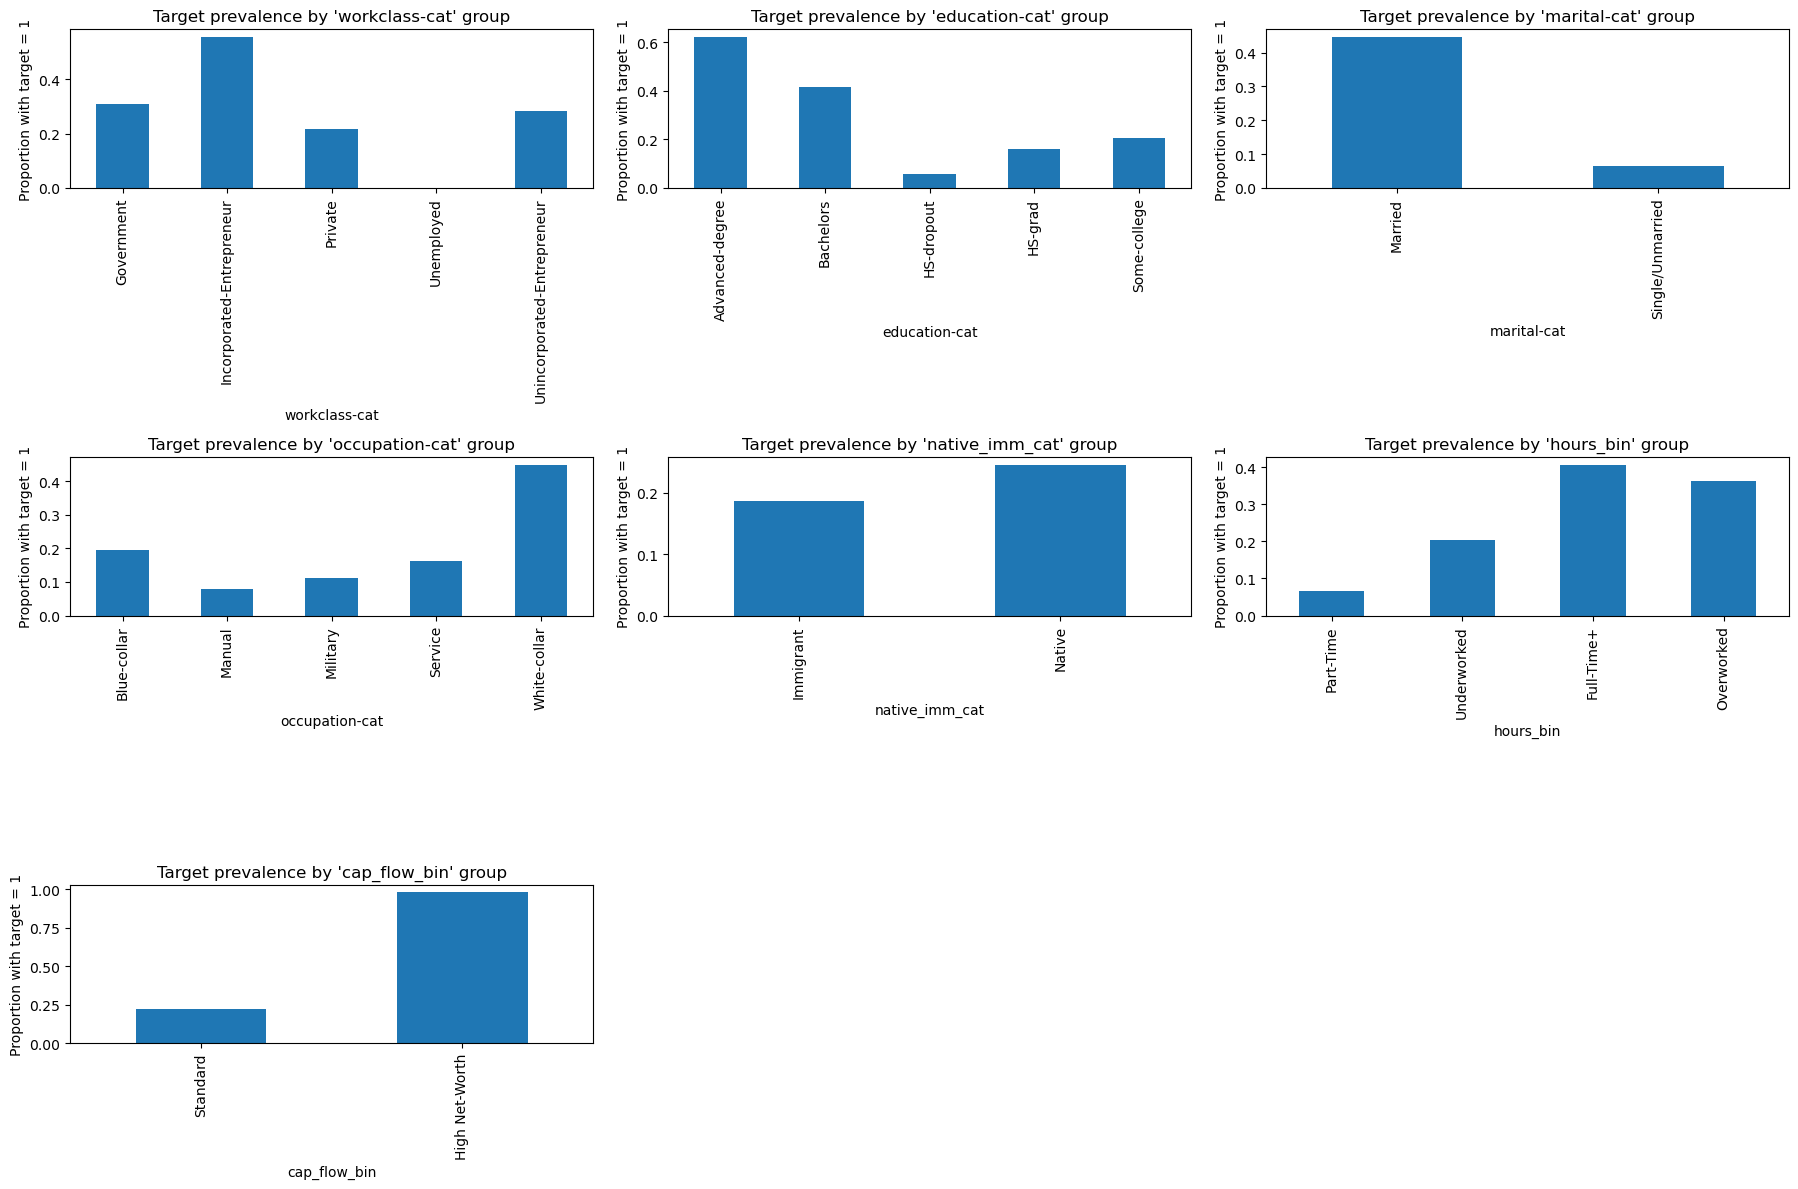

In [254]:
cats = ['workclass-cat','education-cat','marital-cat','occupation-cat','native_imm_cat','hours_bin', 'cap_flow_bin']

plot_prevalence_subplots(chart_df, cats)

## Missing Values

In [255]:
train_df.isna().sum()

age                  0
workclass-cat     1836
education-cat        0
marital-cat          0
occupation-cat    1843
relationship         0
race                 0
sex                  0
native_imm_cat     582
pred                 0
hours_bin            0
cap_flow_bin         0
dtype: int64

In [256]:
test_df.isna().sum()

age                 0
workclass-cat     963
education-cat       0
marital-cat         0
occupation-cat    966
relationship        0
race                0
sex                 0
native_imm_cat    274
pred                0
hours_bin           0
cap_flow_bin        0
dtype: int64

In [257]:
#Columns that have missing values
columns = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}
columns_test = {'workclass-cat', 'occupation-cat', 'native_imm_cat'}

In [258]:
#Print only the columns that contain NA values
for col in columns:
    if train_df[col].isna().any():
        print(f"\n{col}")
        print(train_df[col].unique())


native_imm_cat
['Native' 'Immigrant' nan]

occupation-cat
['Service' 'White-collar' 'Manual' 'Blue-collar' nan 'Military']

workclass-cat
['Government' 'Unincorporated-Entrepreneur' 'Private' nan
 'Incorporated-Entrepreneur' 'Unemployed']


In [259]:
##### TRAIN
#Imputation: mode - 2
train_df_mode = train_df.copy()

for col in columns:
    train_df_mode[col] = train_df_mode[col].fillna(train_df_mode[col].mode()[0])

train_df_mode.isna().sum()

age               0
workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
native_imm_cat    0
pred              0
hours_bin         0
cap_flow_bin      0
dtype: int64

In [260]:
#### TEST
#Imputation: mode - 2
test_df_mode = test_df.copy()

for col in columns_test:
    test_df_mode[col] = test_df_mode[col].fillna(test_df_mode[col].mode()[0])

test_df_mode.isna().sum()

age               0
workclass-cat     0
education-cat     0
marital-cat       0
occupation-cat    0
relationship      0
race              0
sex               0
native_imm_cat    0
pred              0
hours_bin         0
cap_flow_bin      0
dtype: int64

## Correlational Matrix

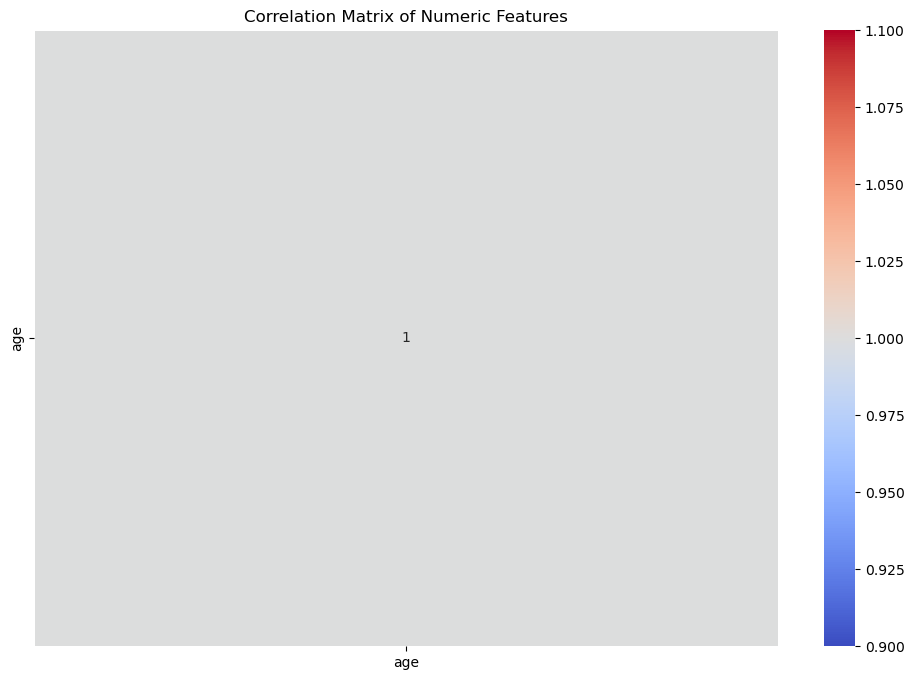

In [261]:
#OHE for numerical features only

# Select numeric columns only
#numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])
numeric_df = train_df_mode.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

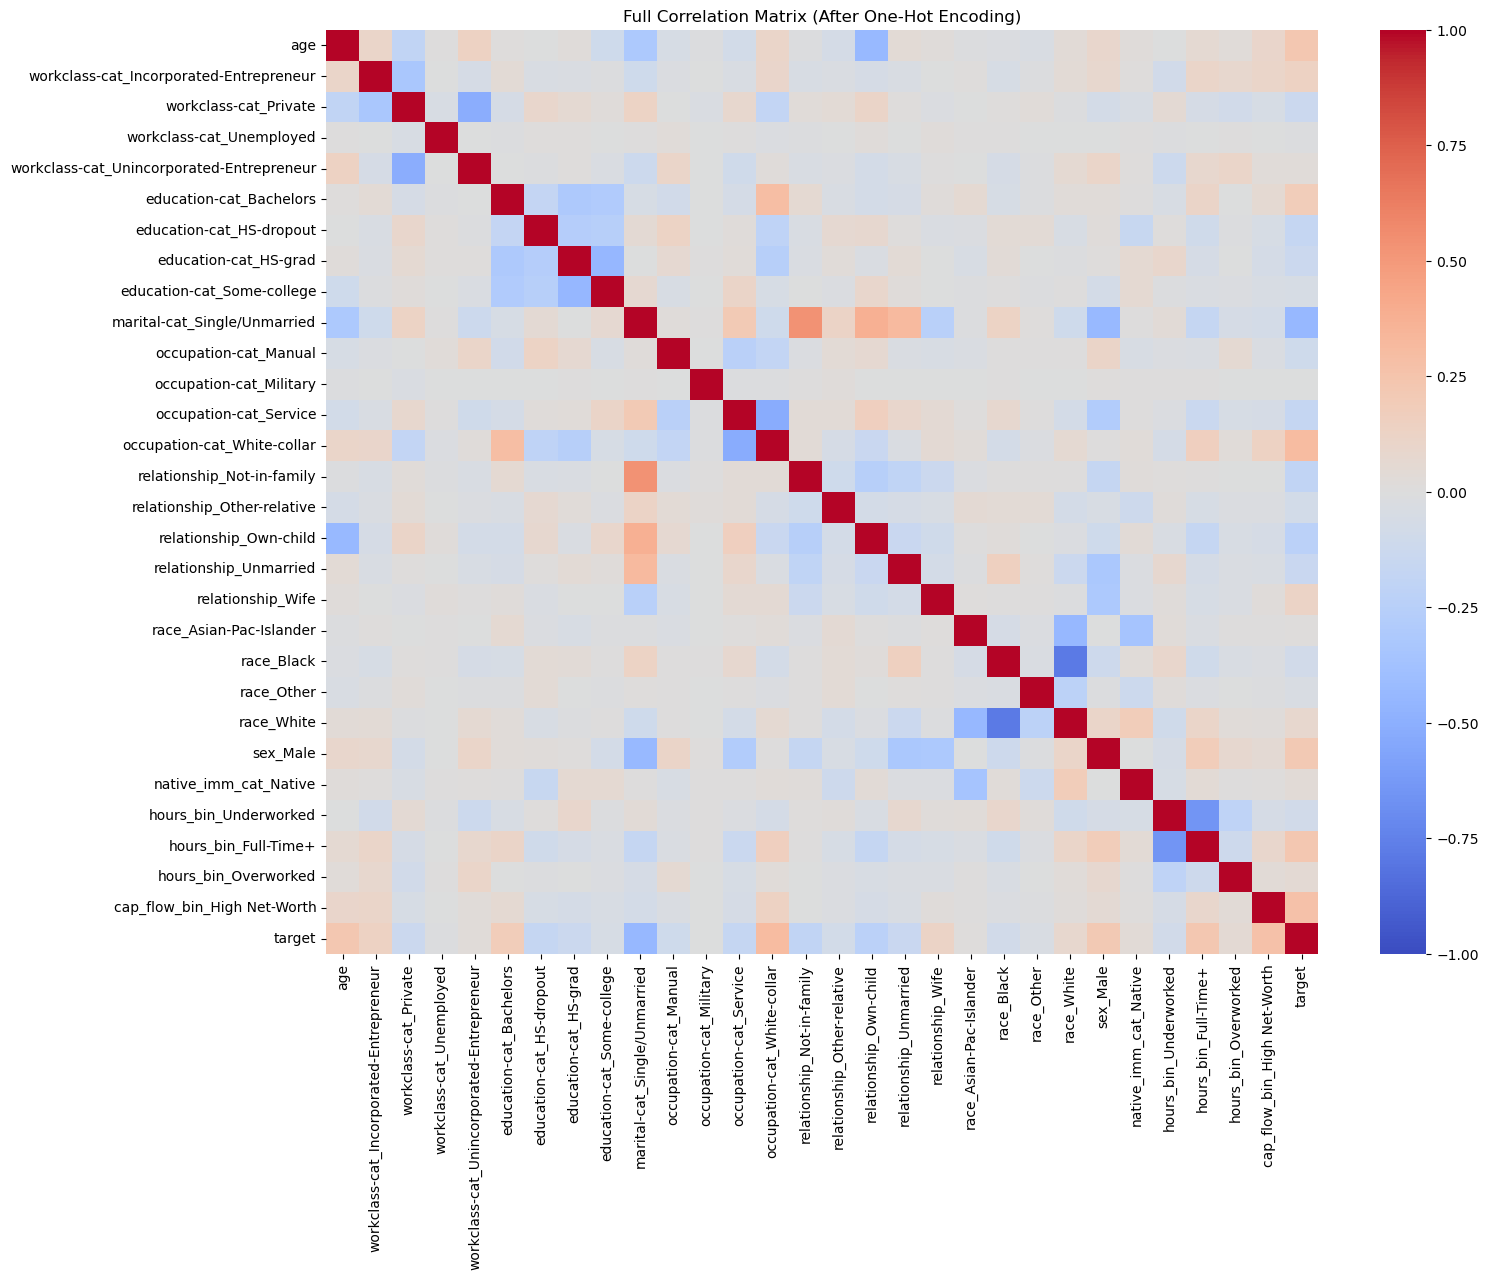

In [262]:
#OHE for correlation matrix

# One-hot encode categorical features
#encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)
encoded_df = pd.get_dummies(train_df_mode.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
#encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)
encoded_df['target'] = train_df_mode['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [263]:
# Convert pred to binary
#binary_corr_df = train_df.copy()
binary_corr_df = train_df_mode.copy()
binary_corr_df['target'] = binary_corr_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(binary_corr_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                                       1.000000
occupation-cat_White-collar                  0.305514
cap_flow_bin_High Net-Worth                  0.269730
age                                          0.234037
hours_bin_Full-Time+                         0.231183
sex_Male                                     0.215969
education-cat_Bachelors                      0.180535
workclass-cat_Incorporated-Entrepreneur      0.139446
relationship_Wife                            0.123230
race_White                                   0.085235
hours_bin_Overworked                         0.054071
native_imm_cat_Native                        0.038702
workclass-cat_Unincorporated-Entrepreneur    0.030017
race_Asian-Pac-Islander                      0.010600
occupation-cat_Military                     -0.005049
workclass-cat_Unemployed                    -0.014317
race_Other                                  -0.031861
education-cat_Some-college                  -0.052184
relationship_Other-relative 

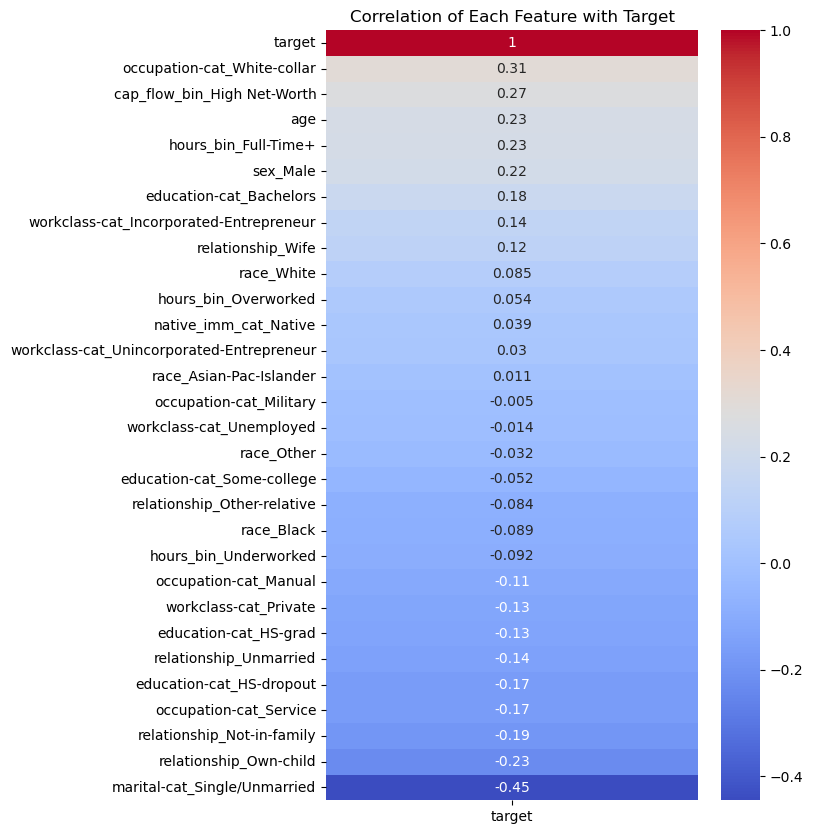

In [264]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [265]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(binary_corr_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


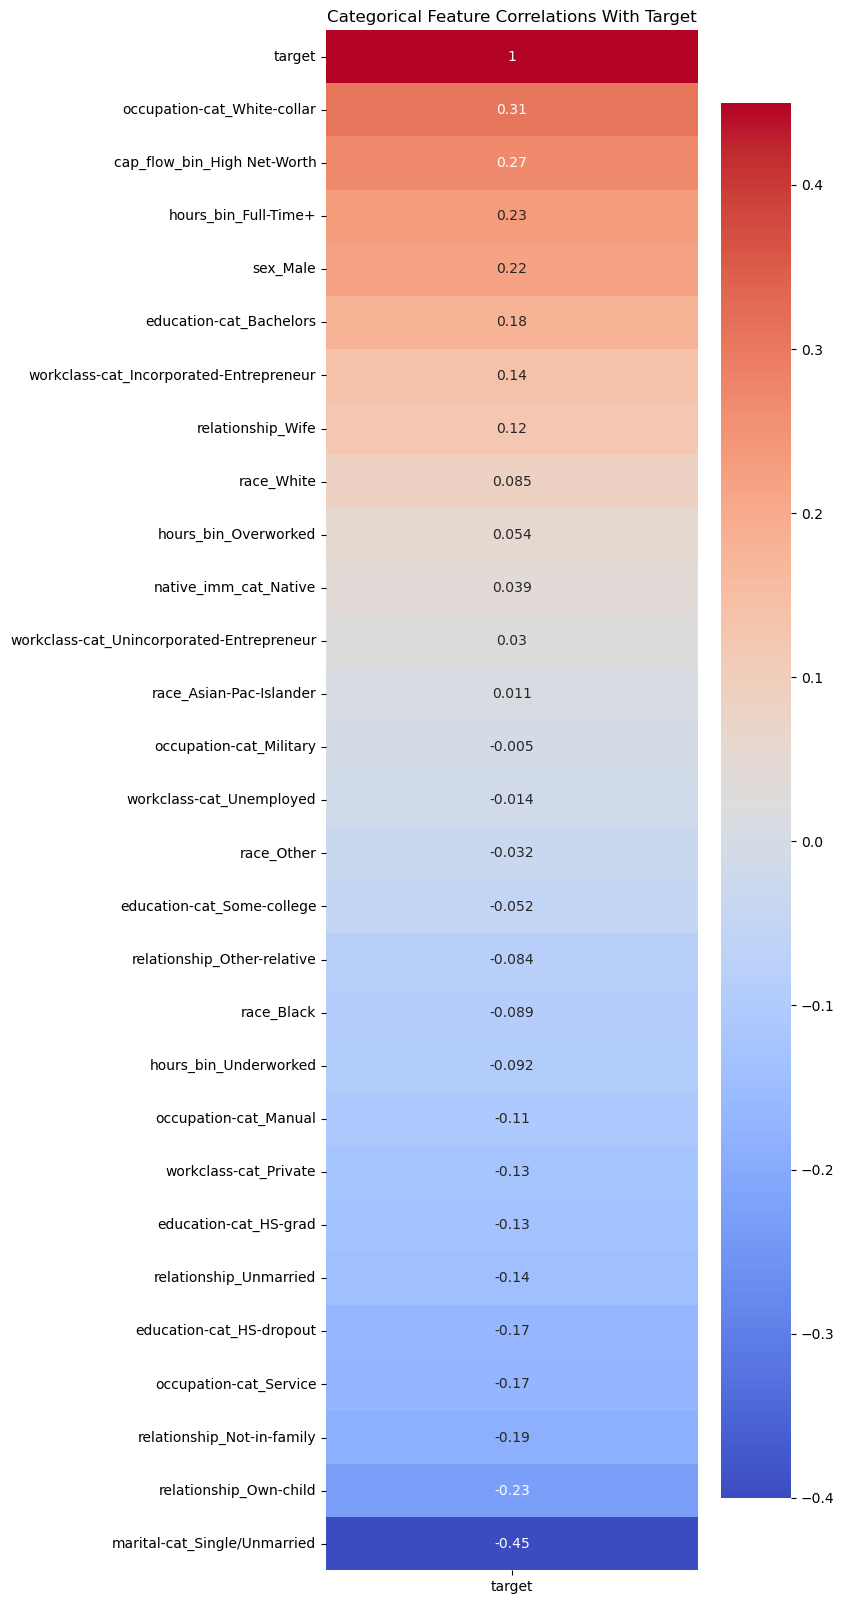

In [266]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [267]:
# Full correlation matrix among remaining categorical columns
cat_corr_matrix = encoded_filtered.corr()

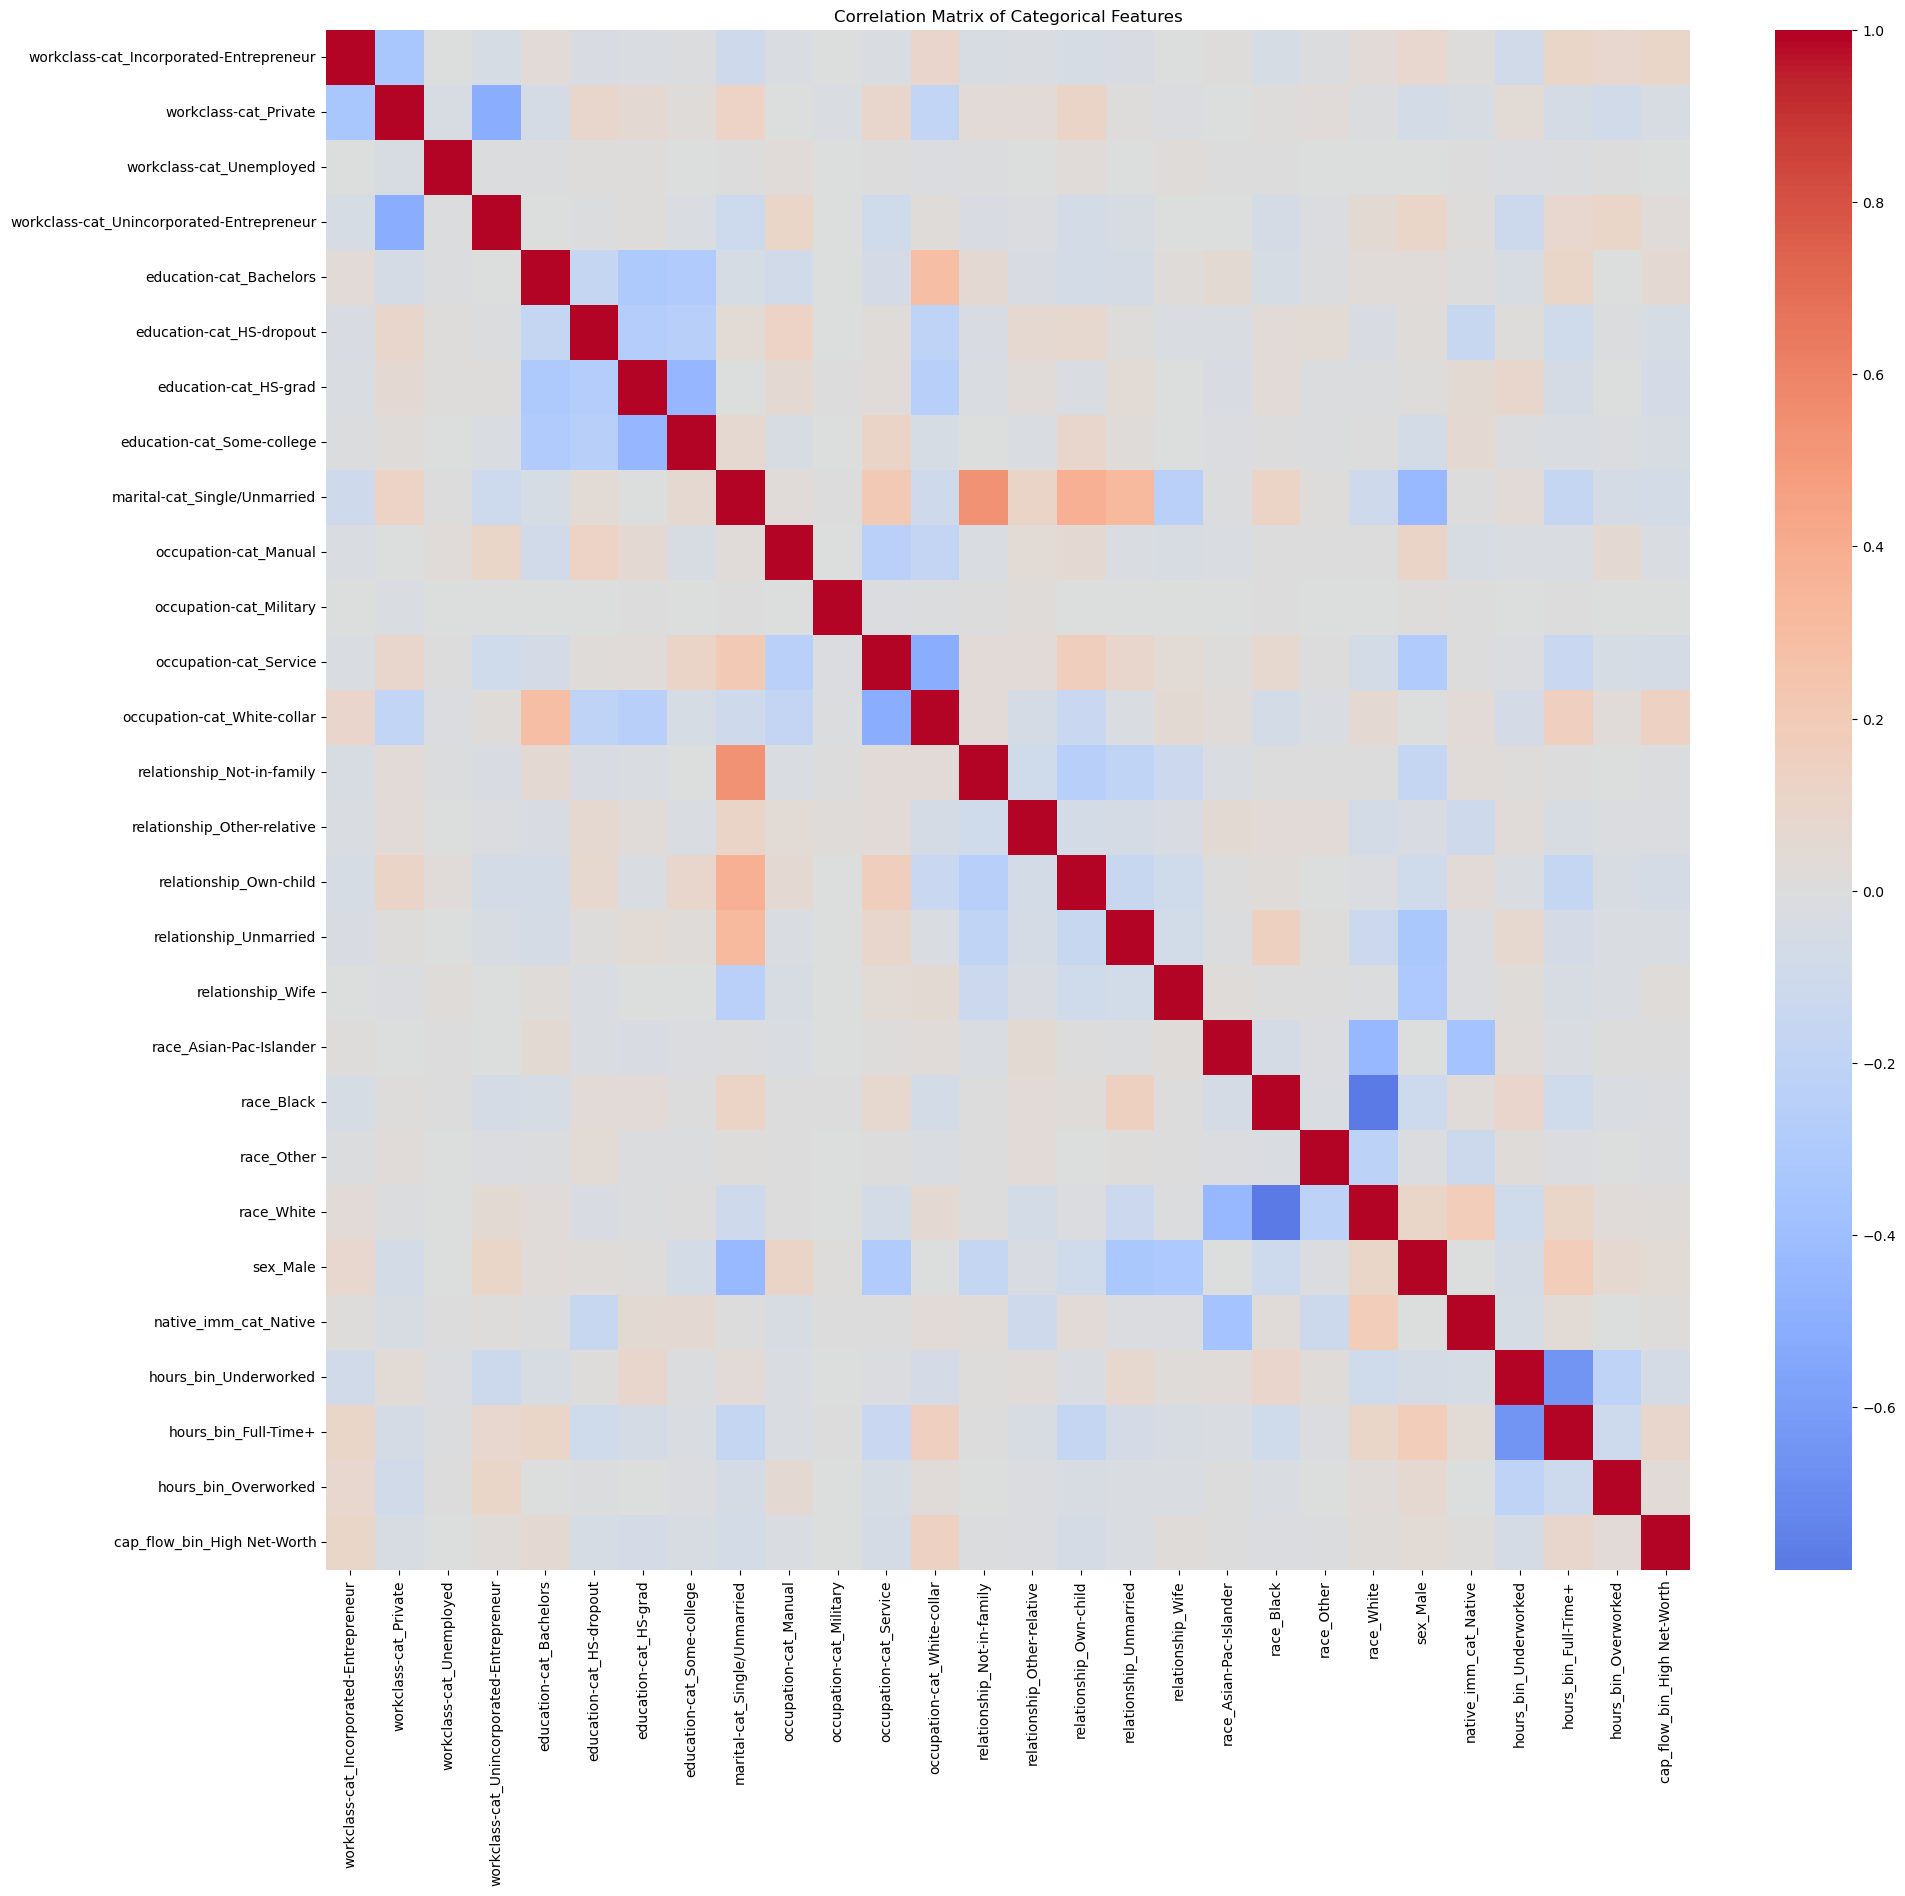

In [268]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()

## Normalization --- Jieun's Part

capital-gain and capital-loss variables are extremely right-skewed with heavy zeros and a few large outliers. Standard normalization (like Min–Max or Z-score) will not work well.

In [269]:
#Log transformation (best for heavy right-skew)
#log_train_df = train_df.copy()
log_train_df = train_df_mode.copy()

log_train_df['capital_gain_log'] = np.log1p(log_train_df['capital-gain'])
log_train_df['capital_loss_log'] = np.log1p(log_train_df['capital-loss'])

#log1p(x) handles zeros safely.
#Compresses extreme values.
#Spreads out dense low-value regions.

KeyError: 'capital-gain'

In [270]:
##for the testing data

#log_train_df = train_df.copy()
log_test_df = test_df_mode.copy()

log_test_df['capital_gain_log'] = np.log1p(log_test_df['capital-gain'])
log_test_df['capital_loss_log'] = np.log1p(log_test_df['capital-loss'])


log_test_df
print(log_test_df['capital_gain_log'].min())
print(log_test_df['capital_gain_log'].max())
print(log_train_df['capital_gain_log'].min())
print(log_train_df['capital_gain_log'].max())

KeyError: 'capital-gain'

KeyError: 'capital_gain_log'

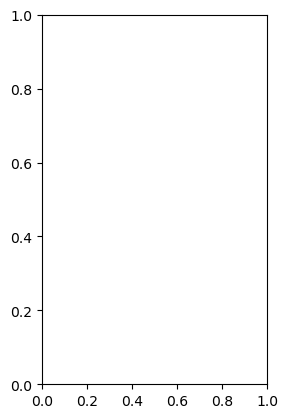

In [271]:
#capital gain
plt.subplot(1, 2, 1)
plt.hist(log_train_df['capital_gain_log'], bins=5)
plt.title("Capital_gain_log")
plt.xlabel("capital_gain_log")
plt.ylabel("Count")

#capital loss
plt.subplot(1, 2, 2)
plt.hist(log_train_df['capital_loss_log'], bins=5)
plt.title("Capital_loss_log")
plt.xlabel("capital_loss_log")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [272]:
log_train_df

,age,workclass-cat,education-cat,marital-cat,occupation-cat,relationship,race,sex,native_imm_cat,pred,hours_bin,cap_flow_bin
0,39,Government,Bachelors,Single/Unmarried,Service,Not-in-family,White,Male,Native,<=50K,Underworked,Standard
1,50,Unincorporated-Entrepreneur,Bachelors,Married,White-collar,Husband,White,Male,Native,<=50K,Part-Time,Standard
2,38,Private,HS-grad,Single/Unmarried,Manual,Not-in-family,White,Male,Native,<=50K,Underworked,Standard
3,53,Private,HS-dropout,Married,Manual,Husband,Black,Male,Native,<=50K,Underworked,Standard
4,28,Private,Bachelors,Married,White-collar,Wife,Black,Female,Immigrant,<=50K,Underworked,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Some-college,Married,White-collar,Wife,White,Female,Native,<=50K,Underworked,Standard
32557,40,Private,HS-grad,Married,Blue-collar,Husband,White,Male,Native,>50K,Underworked,Standard
32558,58,Private,HS-grad,Single/Unmarried,Service,Unmarried,White,Female,Native,<=50K,Underworked,Standard
32559,22,Private,HS-grad,Single/Unmarried,Service,Own-child,White,Male,Native,<=50K,Part-Time,Standard


In [273]:
X_train= log_train_df.drop (['pred', 'capital-gain','capital-loss'],axis=1)
Y_train= log_train_df['pred']

X_test = log_test_df.drop(['pred', 'capital-gain','capital-loss'], axis=1)
Y_test = log_test_df['pred']
#X_test.isna().sum()

KeyError: "['capital-gain', 'capital-loss'] not found in axis"

In [274]:

cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()
print(X_train.columns.tolist())
print(X_test.columns.tolist())
print(train_df['hours_bin'].value_counts())

['age', 'workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'native_imm_cat', 'hours_bin', 'capital_gain_log', 'capital_loss_log']
['age', 'workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'native_imm_cat', 'hours_bin', 'capital_gain_log', 'capital_loss_log']
hours_bin
Underworked    17721
Full-Time+      8466
Part-Time       5240
Overworked      1110
Name: count, dtype: int64


In [275]:
from imblearn.pipeline import Pipeline
imbalances = {
    "none" : "passthrough",
    "under" : RandomUnderSampler(random_state=42),
    "over" : RandomOverSampler(random_state=42)
}
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier" : RandomForestClassifier(random_state=42),
    "Logistic Regression" : LogisticRegression(max_iter=5000,solver="lbfgs"),
    "Bagged Decision Tree": BalancedBaggingClassifier(
        estimator = DecisionTreeClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    ),
    "Bagged Random Forest": BalancedBaggingClassifier(
        estimator = RandomForestClassifier(random_state=42), ## can make more for each 
        n_estimators= 50, 
        sampling_strategy='auto', 
        replacement = False, 
        random_state=42,
        n_jobs=1
    )
}

for imbalance_methods, method in imbalances.items():
    for model_name, clf in models.items():
        if (model_name in ["Bagged Decision Tree", "Bagged Random Forest"]) and imbalance_methods != "none":
            continue
        print (f"\nImbalance Method: {imbalance_methods} \nModel: {model_name} ")

        if model_name == "Bagged Decision Tree":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        elif model_name == "Bagged Random Forest":
                   pipe = Pipeline(steps=[
                       ("encode", preprocess),
                       ("model", clf)
                   ])
        else: 
                   pipe = Pipeline (steps=[
                       ("encode", preprocess),
                       ("imbalances", method),
                       ("model", clf)
                   ])
        pipe.fit(X_train, Y_train)
        y_pred = pipe.predict(X_test)

        print ("test label distribution:", np.unique(Y_test, return_counts=True))
        print ("predicted label distribution:", np.unique (y_pred, return_counts=True))
        print (classification_report(Y_test, y_pred))
        
        
        
            


Imbalance Method: none 
Model: Decision Tree 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([12845,  3431]))
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89     12430
        >50K       0.66      0.59      0.62      3846

    accuracy                           0.83     16276
   macro avg       0.77      0.75      0.76     16276
weighted avg       0.83      0.83      0.83     16276


Imbalance Method: none 
Model: Random Forest Classifier 
test label distribution: (array(['<=50K', '>50K'], dtype=object), array([12430,  3846]))
predicted label distribution: (array(['<=50K', '>50K'], dtype=object), array([12807,  3469]))
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.90     12430
        >50K       0.68      0.61      0.64      3846

    accuracy                          

KeyboardInterrupt: 

In [7]:
class BasicCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df = data_to_str(df)
        df = replace_qmarks(df)
        df = data_to_int32(df)
        return df

class CategoryRemapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df = category_remapping(df)
        return df

# --- Split into X/y ---

target_col = 'pred'

X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# --- Infer final feature types AFTER your custom transforms ---

tmp_cleaner = skPipeline([
    ("basic", BasicCleaner()),
    ("cats", CategoryRemapper()),
])

X_clean = tmp_cleaner.fit_transform(X)

numeric_features = X_clean.select_dtypes(
    include=["int16", "int32", "int64", "float32", "float64"]
).columns.tolist()

categorical_features = X_clean.select_dtypes(
    include=["object", "category"]
).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# --- Column-wise preprocessing ---

numeric_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# --- Final pipelines ---

logreg_pipeline = skPipeline(steps=[
    ("basic_clean", BasicCleaner()),
    ("cat_remap", CategoryRemapper()),
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

Numeric: ['age']
Categorical: ['workclass-cat', 'education-cat', 'marital-cat', 'occupation-cat', 'relationship', 'race', 'sex', 'native_imm_cat', 'hours_bin', 'cap_flow_bin']


In [8]:
logreg_pipeline.fit(X, y)

y_test = test_df['pred']
X_test = test_df.drop('pred', axis=1)

y_pred = logreg_pipeline.predict(X_test)

print("Test score:", logreg_pipeline.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Test score: 0.8431914501566243
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.72      0.56      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.74      0.76     16281
weighted avg       0.84      0.84      0.84     16281



### GridSearch

In [9]:
param_grid = [

    # Logistic Regression scenarios
    {
        "preprocessor__num__imputer__strategy": ["mean", "median"],
        "clf": [LogisticRegression(max_iter=1000)],
        "clf__C": [0.1, 1.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    },

    # Random Forest scenarios
    {
        "preprocessor__num__imputer__strategy": ["mean", "median"],
        "clf": [RandomForestClassifier(random_state=42, n_jobs=-1)],
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 10, 20],
    },

]

grid = GridSearchCV(
    estimator=logreg_pipeline,  # base pipeline; clf will be overridden by grid
    param_grid=param_grid,
    cv=5,
    #scoring="roc_auc",
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_

X_test = test_df.drop(columns=["pred"])
y_test = test_df["pred"]

print("Test ROC AUC:", grid.score(X_test, y_test))

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'clf': RandomForestClassifier(n_jobs=-1, random_state=42), 'clf__max_depth': 10, 'clf__n_estimators': 400, 'preprocessor__num__imputer__strategy': 'mean'}
Best CV score: 0.8439545309305789
Test ROC AUC: 0.8473066764940729
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12435
           1       0.74      0.54      0.62      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.74      0.76     16281
weighted avg       0.84      0.85      0.84     16281

